In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
class PositionalEmbedding1D(nn.Module):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        # (1, 3, 14, 14) + (1, 3, 196) ? wtf
        # ohhh flatten before embedding kek
        return x + self.pos_embedding

In [3]:
class MLP(nn.Module):
    def __init__(self, dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, dim)
        
    def forward(self, x):
        out = self.fc2(F.gelu(self.fc1(x)))
        return out

In [4]:
class MHSA(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.q_project = nn.Linear(dim, dim)
        self.k_project = nn.Linear(dim, dim)
        self.v_project = nn.Linear(dim, dim)
        self.out_project = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(0.)
        
    def forward(self, x): # input shape [b, s, d]
        # split into q, k, v : (query, key, values)
        # expand by h (num heads... hence multi attention)
        
        q, k, v = self.q_project(x), self.k_project(x), self.v_project(x)
        # convert q, k, v -> [b, h, s, w] where h = n_heads
        # linearly project to refactor new features where new features are a weighted sum of the old features
        # MHSA blocks will learn which features are important, hence attention. certain chunks of the image will have greater weight/importanc and attention will be greater
        '''
        b, s, d -> b, h, s, w
        b, 197, 768 -> b, 12, 196, 64
        torch.view should work here, if not use something else ig :/
        '''
        q = q.view(q.shape[0], self.n_heads, q.shape[1], -1)
        k = k.view(k.shape[0], self.n_heads, k.shape[1], -1)
        v = v.view(v.shape[0], self.n_heads, v.shape[1], -1)
        
        # scaled dot product attention on q, k (queries, keys) then matmul with values
        # matmul + scale
        # [b, h, s, w] @ [b, h, w, s] -> [b, h, s, s]
        '''
        p should be (b, 197, 197)
        '''
        k = k.transpose(-2, -1) # swap last two dimensions
        # import pdb; pdb.set_trace()
        p = torch.matmul(q, k)
        p = p / np.sqrt(k.size(-1)) # where s is the dimension of k. p represents scalar dot product (all combinations of query-key pairs)

        p = self.dropout(F.softmax(p, dim = -1)) # softmax across last dimension. zero some q-k weights... why?
        
        '''
        need to apply .contiguous() on a tranposed tensor if you want to reshape it with .view()
        out should be (b, 197, 768)
        output: reweighted tensor with applied attention, certain patches are more important/relevant in classifying this specific image
        '''
        out = torch.matmul(p, v).transpose(1, 2) # [b, h, s, s] @ [b, h, s, w] -> [b, s, h, w]. i dont even think i need to call contiguous here
        out = out.flatten(2) # [b, s, d]
        out = self.out_project(out)
        return out

In [5]:
# dont need linear and dont need dropout i think
# add after if performance is shit

# ADDED DROPOUT LAYERS
'''
generally apply dropout layers in front of linear projections
    dropout before MHSA/MLP where the last layer in a linear projection
    why dropout in front of softmax then? 
'''

class Block(nn.Module): # inputs are B, S, D
    def __init__(self, dim, n_heads, ff_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.MHSA = MHSA(dim, n_heads)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp_channels = MLP(dim, ff_dim)
        self.dropout = nn.Dropout(0.)
        
    def forward(self, x):
        h = self.dropout(self.MHSA(self.norm1(x)))
        x = x + h
        h = self.dropout(self.mlp_channels(self.norm2(x)))
        x = x + h
        return x

In [6]:
class Transformer(nn.Module):
    def __init__(self, n_layers, dim, n_heads, ff_dim):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, n_heads, ff_dim) for _ in range(n_layers)])
    
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [7]:
'''
with image 1, 3, 224, 224  and patch encoding of 16x16 we have
((224 - 16) / 16) + 1 = 14
seq len is 14 * 14 bro im trippin bullets
out = (1, 3, 14, 14)
'''

'\nwith image 1, 3, 224, 224  and patch encoding of 16x16 we have\n((224 - 16) / 16) + 1 = 14\nseq len is 14 * 14 bro im trippin bullets\nout = (1, 3, 14, 14)\n'

In [8]:
class ViT(nn.Module):
    def __init__(self, in_channels, dim, fh, fw, n_layers, n_heads, ff_dim, num_classes):
        super().__init__()
        self.fw = fw
        self.fh = fh
        self.patch_encoding = nn.Conv2d(in_channels, dim, kernel_size=(self.fh, self.fw), stride=(self.fh, self.fw))
        # [B, D, FH, FW]
        
        seq_len = 14 * 14 + 1 # for cls token
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
            
        self.positional_embedding = PositionalEmbedding1D(seq_len, dim) # inputs are seq len, dim
        # [B, D, FH, FW]
        
        # flatten into [B, S, D]
        self.Transformer = Transformer(n_layers, dim, n_heads, ff_dim)
        
        # if this doenst work then do it manually
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.head = nn.Linear(dim, num_classes)
        
        # fine tune layer
        self.finetune = nn.Linear(num_classes, 6)
        
    def forward(self, x):
        b = x.shape[0] # batch size
        x = self.patch_encoding(x) # [b, 768, 14, 14] out of the conv layer
        # import pdb; pdb.set_trace()
        x = x.flatten(2).transpose(1, 2) # [1, 768, 196] -> [1, 196, 768]
        cls_token = self.cls_token.expand(b, -1, -1) # expand to batch size
        x = torch.cat([cls_token, x], axis=1)
        
        x = self.positional_embedding(x) 
        x = self.Transformer(x)
        x = self.norm(x)
        '''
        this step is extremely fuckign sus bro... like why just drop the entire sequence????
        '''
        x = x[:, 0] # use cls token for MLP head
        x = self.head(x)
        x = self.finetune(x)
        return x

In [9]:
#hyperparameters
fw = fh = 16
dim = 768
ff_dim = 3072
n_heads = 12
n_layers = 12
in_channels = 3
num_classes = 1000

In [10]:
model = ViT(in_channels, dim, fh, fw, n_layers, n_heads, ff_dim, num_classes)

In [11]:
x = torch.load("b16.pth")

In [12]:
from collections import OrderedDict

In [13]:
d = OrderedDict()

In [14]:
for i, j in x.items():
    if i[:7] == "blocks.":
        newkey = "Transformer." + i
        d[newkey] = j
    else:
        d[i] = j

In [15]:
dd = OrderedDict()

In [16]:
for i, j in d.items():
    if i[21:31] != 'mlp_tokens':
        dd[i] = j

In [17]:
ddd = OrderedDict()

In [18]:
for i, j in dd.items():
    if i[22:32] != 'mlp_tokens':
        ddd[i] = j

In [19]:
# fuck the rest of these weights
model.load_state_dict(ddd, strict=False)

_IncompatibleKeys(missing_keys=['cls_token', 'patch_encoding.weight', 'patch_encoding.bias', 'positional_embedding.pos_embedding', 'Transformer.blocks.0.MHSA.q_project.weight', 'Transformer.blocks.0.MHSA.q_project.bias', 'Transformer.blocks.0.MHSA.k_project.weight', 'Transformer.blocks.0.MHSA.k_project.bias', 'Transformer.blocks.0.MHSA.v_project.weight', 'Transformer.blocks.0.MHSA.v_project.bias', 'Transformer.blocks.0.MHSA.out_project.weight', 'Transformer.blocks.0.MHSA.out_project.bias', 'Transformer.blocks.1.MHSA.q_project.weight', 'Transformer.blocks.1.MHSA.q_project.bias', 'Transformer.blocks.1.MHSA.k_project.weight', 'Transformer.blocks.1.MHSA.k_project.bias', 'Transformer.blocks.1.MHSA.v_project.weight', 'Transformer.blocks.1.MHSA.v_project.bias', 'Transformer.blocks.1.MHSA.out_project.weight', 'Transformer.blocks.1.MHSA.out_project.bias', 'Transformer.blocks.2.MHSA.q_project.weight', 'Transformer.blocks.2.MHSA.q_project.bias', 'Transformer.blocks.2.MHSA.k_project.weight', 'Tran

# load dataset and train

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import sys
import torchvision
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
import os
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.utils import shuffle

In [21]:
labels = ['street', 'sea', 'mountain', 'glacier', 'forest', 'buildings']

In [22]:
image_size = (224, 224)

# bro i cant even blame the vit model this get data function is just fucked LOL

### need to resize to 224 x 224 and shape (3, 224, 224)

In [23]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image, (224, 224)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            image = image.reshape(3, 224, 224) # RESHAPE TO CHANNEL FIRST
            image = image / 255 # NORMALIZE
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [24]:
images, labels = get_images('D:/Data/intel/seg_train/')

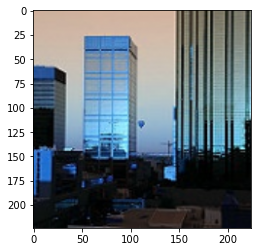

In [25]:
plt.imshow(images[9000].reshape(224, 224, 3))

In [26]:
class TorchData(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [27]:
dataset = TorchData(images, labels)

In [28]:
train, val = torch.utils.data.random_split(dataset, [11226, 2808])

## nn.CrossEntropyLoss doesnt take one hot

In [29]:
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=8)
valloader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=8)

In [30]:
device = torch.device('cuda')
import torch.optim as optim

In [31]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
# has softmax in it
loss = nn.CrossEntropyLoss()

In [33]:
model.train()

ViT(
  (patch_encoding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (Transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (q_project): Linear(in_features=768, out_features=768, bias=True)
          (k_project): Linear(in_features=768, out_features=768, bias=True)
          (v_project): Linear(in_features=768, out_features=768, bias=True)
          (out_project): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
        (n

In [34]:
# this thing is probably gonna overfit but full send i sleep and check reuslts in morning

In [35]:
training_losses = []
val_losses = []
avg_training_losses = []
avg_val_losses = []

In [36]:
losses = []
for e in tqdm(range(10)):
    for x, y in trainloader:
        torch.cuda.empty_cache()
        x, y = x.to(device), y.to(device)
        x = x.float()
        
        # train step
        optimizer.zero_grad()
        y_pred = model(x)
        l = loss(y_pred, y)
        t_l = l.detach().cpu().numpy()
        l.backward()
        optimizer.step()
        
        training_losses.append(t_l)
    
    # with torch.no_grad() but this doesnt really make that big of a difference
    for i, j in valloader:
        # no optim zero grad, step, l.backward
        i, j = i.to(device), j.to(device)
        i = i.float()
        
        y_pred = model(i)
        ll = loss(y_pred, j)
        v_l = ll.detach().cpu().numpy()
        
        val_losses.append(v_l)
        
    avg_training_losses.append(np.mean(training_losses))
    avg_val_losses.append(np.mean(val_losses))
        
    print(f' *** Training Loss: {np.mean(training_losses)}, Validation Loss: {np.mean(val_losses)} *** ')

 10%|████████▏                                                                         | 1/10 [04:39<41:55, 279.48s/it]

 *** Training Loss: 1.6134259700775146, Validation Loss: 1.385842204093933 *** 


 20%|████████████████▍                                                                 | 2/10 [09:08<36:25, 273.24s/it]

 *** Training Loss: 1.4958800077438354, Validation Loss: 1.423689842224121 *** 


 30%|████████████████████████▌                                                         | 3/10 [13:37<31:39, 271.31s/it]

 *** Training Loss: 1.4369295835494995, Validation Loss: 1.3738332986831665 *** 


 40%|████████████████████████████████▊                                                 | 4/10 [17:59<26:46, 267.71s/it]

 *** Training Loss: 1.3863749504089355, Validation Loss: 1.3398000001907349 *** 


 50%|█████████████████████████████████████████                                         | 5/10 [22:27<22:18, 267.79s/it]

 *** Training Loss: 1.3647183179855347, Validation Loss: 1.3432931900024414 *** 


 60%|█████████████████████████████████████████████████▏                                | 6/10 [26:49<17:43, 265.96s/it]

 *** Training Loss: 1.3680291175842285, Validation Loss: 1.3404983282089233 *** 


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [31:17<13:19, 266.36s/it]

 *** Training Loss: 1.3786120414733887, Validation Loss: 1.370476245880127 *** 


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [35:44<08:53, 266.67s/it]

 *** Training Loss: 1.4011187553405762, Validation Loss: 1.4095040559768677 *** 


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [40:15<04:27, 267.98s/it]

 *** Training Loss: 1.409366250038147, Validation Loss: 1.3987984657287598 *** 


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [44:46<00:00, 268.65s/it]

 *** Training Loss: 1.4081377983093262, Validation Loss: 1.40605890750885 *** 


## maybe training and validation loss have to converge first then they start going down together :O
#### PLEASE BE THE CASE IM SO FUCKING DONE WITH THIS
#### NAH BRO I SWEAR THEYRE BOTH JUST STUCK AFTER LIKE 3 EPOCHS

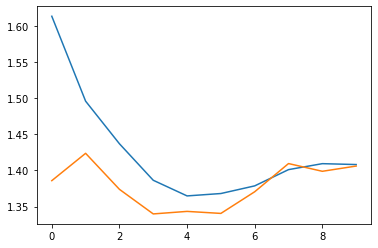

In [37]:
plt.plot(avg_training_losses)
plt.plot(avg_val_losses)

In [38]:
model.eval()

ViT(
  (patch_encoding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (Transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (q_project): Linear(in_features=768, out_features=768, bias=True)
          (k_project): Linear(in_features=768, out_features=768, bias=True)
          (v_project): Linear(in_features=768, out_features=768, bias=True)
          (out_project): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
        (n

In [39]:
a, b = [], []

for x, y in valloader:
    x, y = x.to(device), y.to(device)
    x = x.float()
    y_pred = model(x)
    y_pred, y = y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()
    yes = np.argmax(y_pred, axis=1)
    a.append(yes)
    b.append(y)

In [40]:
count = 0
for i, j in zip(a, b):
    for k, l in zip(i, j):
        if k == l:
            count += 1

In [41]:
# fuck this
count/2808

0.4188034188034188

In [42]:
r, t = [], []

for x, y in trainloader:
    x, y = x.to(device), y.to(device)
    x = x.float()
    y_pred = model(x)
    y_pred, y = y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()
    yes = np.argmax(y_pred, axis=1)
    r.append(yes)
    t.append(y)

In [45]:
count2 = 0
for i, j in zip(r, t):
    for k, l in zip(i, j):
        if k == l:
            count2 += 1

In [46]:
count2/12630

0.3808392715756136

* yo thats pretty insane for 10 epochs of training wtf
* i used a bare minimum cnn architecture and it got 50% accuracy a while ago on this dataset and it trained on 90% 10% and this one trained on 50 50 lmao
* this is also highly unoptimized i just did the bare minimum to try to get it to work
* its pretty dope how it could learn hella fast from having 1000 num classes parameters tho

## to do:
#### figure out a cleaner way to load state dict from pretrained weights
#### figure out how to fine tune like a non idiot
### clean up all code and refactor into clean structure